### Model Predictive Controller (MPC) Design



In [212]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

# The system matrices A1 and B are given as those of the Kothare's paper (please see the page 1368).
A1 = np.matrix([[0.9347, 0.5194],[0.3835, 0.8310]])
A2 = np.matrix([[0.9347+0.1, 0.5194],[0.3835+0.1, 0.8310]])

B = np.matrix([[-1.4462],[-0.7012]])

# Simulation parmeters
umax = 50 # Feasible solution can be obtained upto umax=47.0
n=A1.shape[0]
b=B.shape[1]
x0=np.matrix([[0.1],[-0.1]])
N1 = np.matrix([[1]])

I = np.identity(n)
Ib = np.identity(b)
Zn = np.zeros((n,n))
Znb = np.zeros((n,b))

Q=0.1*I
R=0.1*Ib
Qf = fractional_matrix_power(Q, 0.5)
Rf = fractional_matrix_power(R, 0.5)

# Decision variable matrices are defined.
P = cp.Variable((n,n), PSD=True)
Y = cp.Variable((b,n))
gamma = cp.Variable((1,1), PSD=True)

# LMI conditions
LMI1 = cp.bmat([[P, P*A1.T+Y.T*B.T, P*Qf, Y.T*Rf],
        [(P*A1.T+Y.T*B.T).T, P, Zn, Znb],
        [(P*Qf).T, Zn, gamma*I, Znb],
        [(Y.T*Rf).T, Znb.T, Znb.T, gamma*Ib]])

LMI2 = cp.bmat([[P, P*A2.T+Y.T*B.T, P*Qf, Y.T*Rf],
        [(P*A2.T+Y.T*B.T).T, P, Zn, Znb],
        [(P*Qf).T, Zn, gamma*I, Znb],
        [(Y.T*Rf).T, Znb.T, Znb.T, gamma*Ib]])

LMI3 = cp.bmat([[N1, x0.T],[x0, P]])

LMI4 = cp.bmat([[(umax**2)*Ib, Y],[Y.T, P]])

objective = cp.Minimize(gamma)
constraints = [LMI1>= 0, LMI2>= 0, LMI3>= 0, LMI4>= 0, P - 0.01*I >= 0, gamma >> 0] 
prob = cp.Problem(objective, constraints)
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)

# Obtaining feasible solutions
Pop = P.value
Yop = Y.value
gamop = gamma.value
Pinv = np.linalg.inv(Pop)
K = np.matmul(Yop,Pinv) # K1 = Yop@Pinv, K1 is the same as K

# Stability check => |eig of (A+BK)|<= 1
[sys_stab1,sys_vec] = np.linalg.eig(A1+B@K)
[sys_stab2,sys_vec] = np.linalg.eig(A2+B@K)
print(gamop)
print(sys_stab1)
print(sys_stab2)


status: optimal_inaccurate
optimal value 3.0566505376817285e-06
[[3.05665054e-06]]
[0.37431812 0.65398447]
[0.42525669 0.70304591]


In the MPC algorithm, the optimal gain $K$ is computed at each iteration, but we will fix the gain $K$ for the simple code.


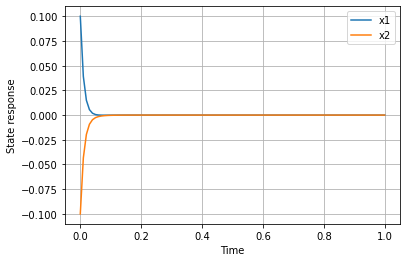

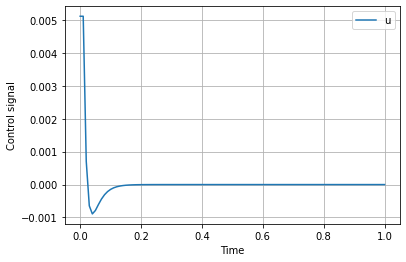

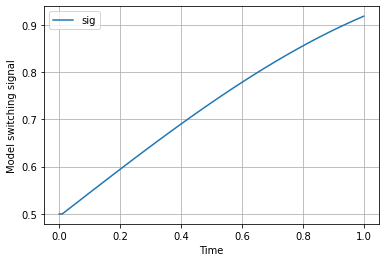

In [223]:
# Simulation
x0 = np.array(x0)
dx = np.zeros([n,b])
temp_p = np.zeros([n,b])

T=0.01
tf=1
sam=int(tf/T)
tspan = np.linspace(0,tf, sam+1)

xs=len(tspan)
x=np.zeros([n,xs])
u_sig=np.zeros([B.shape[1],xs])
temp_sig=np.zeros([1,xs])
temp_sig[0,0]=(0.5)*np.sin(0)+0.5
x[0,0]=x0[0]
x[1,0]=x0[1]

u_sig[:,0] = np.matmul(K,x[:,0])

for i in range(0,xs-1):
    u = np.matmul(K,x[:,i])
    sig = (0.5)*np.sin(i*T)+0.5
    #sig = 0
    A2 = np.matrix([[0.9347+0.1, 0.5194],[0.3835+0.1, 0.8310]])
    dx1 = sig*(0.9347*x[0,i]+0.5194*x[1,i]) + (1-sig)*((0.9347+0.1)*x[0,i]+0.5194*x[1,i]) - 1.4462*u
    dx2 = sig*(0.3835*x[0,i]+0.8310*x[1,i]) + (1-sig)*((0.3835+0.1)*x[0,i]+(0.8310)*x[1,i]) - 0.7012*u
    x[0,i+1] = dx1
    x[1,i+1] = dx2
    temp_sig[0,i+1] = sig
    u_sig[:,i+1] = u

plt.figure()
plt.plot(tspan, x[0,:], label = "x1")
plt.plot(tspan, x[1,:], label = "x2")
plt.grid()
plt.xlabel("Time")
plt.ylabel("State response")
plt.legend()
plt.show()

plt.figure()
plt.plot(tspan, u_sig[0,:], label = "u")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Control signal")
plt.legend()
plt.show()

plt.figure()
plt.plot(tspan, temp_sig[0,:], label = "sig")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Model switching signal")
plt.legend()
plt.show()
